# A lost cause?

**We'd like to predict drilling problems from some basic parameters about a well.**

We'll have to be careful not to cheat: several of the known facts about a well (for example, the date TD was reached) might only be known after drilling, so would not be very useful as a predictor.

We're going to use data from Norway: https://factpages.npd.no/en/wellbore/statistics/entryyear

In [1]:
url = ("https://factpages.npd.no/ReportServer_npdpublic"
       "?/FactPages/tableview/wellbore_exploration_all"
       "&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f"
       "&IpAddress=not_used&CultureCode=en&rs:Format=CSV&Top100=false")

In [2]:
import pandas as pd

df_orig = pd.read_csv(url)

In [3]:
df_orig.head()

,wlbWellboreName,wlbWell,wlbDrillingOperator,wlbProductionLicence,wlbPurpose,wlbStatus,wlbContent,wlbWellType,wlbSubSea,wlbEntryDate,...,wlbNpdidWellbore,dscNpdidDiscovery,fldNpdidField,fclNpdidFacilityDrilling,wlbNpdidWellboreReclass,prlNpdidProductionLicence,wlbNpdidSiteSurvey,wlbDateUpdated,wlbDateUpdatedMax,datesyncNPD
0,1/2-1,1/2-1,Phillips Petroleum Norsk AS,143,WILDCAT,P&A,OIL,EXPLORATION,NO,20.03.1989,...,1382,43814.0,3437650.0,296245.0,0,21956.0,NaN,23.02.2021,22.08.2021,08.03.2022
1,1/2-2,1/2-2,Paladin Resources Norge AS,143 CS,WILDCAT,P&A,OIL SHOWS,EXPLORATION,NO,14.12.2005,...,5192,NaN,NaN,278245.0,0,2424919.0,NaN,23.02.2021,03.10.2019,08.03.2022
2,1/3-1,1/3-1,A/S Norske Shell,011,WILDCAT,P&A,GAS,EXPLORATION,NO,06.07.1968,...,154,43820.0,NaN,288604.0,0,20844.0,NaN,23.02.2021,22.08.2021,08.03.2022
3,1/3-2,1/3-2,A/S Norske Shell,011,WILDCAT,P&A,DRY,EXPLORATION,NO,14.05.1969,...,165,NaN,NaN,288847.0,0,20844.0,NaN,23.02.2021,22.08.2021,08.03.2022
4,1/3-3,1/3-3,Elf Petroleum Norge AS,065,WILDCAT,P&A,OIL,EXPLORATION,NO,22.08.1982,...,87,43826.0,1028599.0,288334.0,0,21316.0,NaN,23.02.2021,22.08.2021,08.03.2022


There should be at least 2000 rows, and 87 columns.

In [4]:
df_orig.shape

(2011, 87)

## Data exploration

#### EXERCISE

Take a look at some of the columns in the data. Think about the following:

- What should the target be?
- Which columns might be useful?
- Which columns might need to be transformed in some way to make them more useful?

Pull out a few columns and transform them as needed.

In [ ]:
# YOUR CODE HERE



Might seem at first like 'drilling days' is the thing to go for, but ROP might be fairer, because drilling days depends strongly on the target. Comes down to what we're trying to do with the model.

Useful columns include those in the `cols` variable below.

Some columns contain information that does not vary, for example:

- `wlbPurposePlanned`
- `wlbMultilateral`

UTMx and UTMy are tricky to reconcile because of UTM zones, beware! Lat and lon are safer, but nonlinear, especially far north.

Things like year/month and deg/min/sec need to be turned into continuous numbers if they are to be used. Note that month is a useful feature on its own (as a proxy for the weather), but it might be smart to make a rotated version that is circular (otherwise December seems very different to January). I'm going to use Year (only, for historical time) and Month (for season) separately.

Others could not be known ahead of time, eg the result of the well. Well temperature is arguable, you could  model it ahead of time, but how accurately?

Still other features would be hard to make useful, eg `wlbDrillingOperator` (it's pretty clean, but it would need one-hot encoding, and companies like Equinor appear as about 5 different companies over time).

**Could ask them and chat about encoding features like `wlbPurpose` (binary) vs `wlbDrillingOperator` (one-hot).**

In [5]:
df_orig.columns

Index(['wlbWellboreName', 'wlbWell', 'wlbDrillingOperator',
       'wlbProductionLicence', 'wlbPurpose', 'wlbStatus', 'wlbContent',
       'wlbWellType', 'wlbSubSea', 'wlbEntryDate', 'wlbCompletionDate',
       'wlbField', 'wlbDrillPermit', 'wlbDiscovery', 'wlbDiscoveryWellbore',
       'wlbBottomHoleTemperature', 'wlbSiteSurvey', 'wlbSeismicLocation',
       'wlbMaxInclation', 'wlbKellyBushElevation', 'wlbFinalVerticalDepth',
       'wlbTotalDepth', 'wlbWaterDepth', 'wlbKickOffPoint', 'wlbAgeAtTd',
       'wlbFormationAtTd', 'wlbMainArea', 'wlbDrillingFacility',
       'wlbFacilityTypeDrilling', 'wlbDrillingFacilityFixedOrMoveable',
       'wlbLicensingActivity', 'wlbMultilateral', 'wlbPurposePlanned',
       'wlbEntryYear', 'wlbCompletionYear', 'wlbReclassFromWellbore',
       'wlbReentryExplorationActivity', 'wlbPlotSymbol', 'wlbFormationWithHc1',
       'wlbAgeWithHc1', 'wlbFormationWithHc2', 'wlbAgeWithHc2',
       'wlbFormationWithHc3', 'wlbAgeWithHc3', 'wlbDrillingDays', 'wlbRee

In [6]:
# Seem useful...
cols = [
    'wlbWell',
    'wlbDrillingFacilityFixedOrMoveable',  # Moveable, Fixed
    'wlbPurpose',  # Wildcat, Appraisal
    'wlbEntryDate',  # Split into month, year features
    'wlbEwDeg', 'wlbEwMin', 'wlbEwSec',
    'wlbNsDeg', 'wlbNsMin', 'wlbNsSec',
    'wlbKellyBushElevation',
    'wlbTotalDepth',
    'wlbWaterDepth',
    'wlbMaxInclation',
    'wlbBottomHoleTemperature',
    'wlbAgeAtTd',
    'wlbFactPageUrl', # Nice to have
    'wlbDrillingDays',  # Target
]
df = df_orig[cols]
df = df.dropna(axis=0)

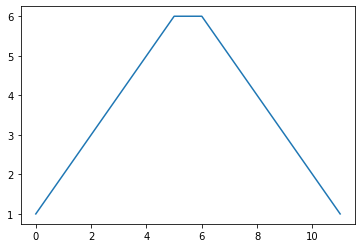

In [8]:
import matplotlib.pyplot as plt

def month_transformer(m):
    """
    Make a 'season' proxy, circular version of month.
    Quick and dirty, not vectorized.
    """
    return m if m < 7 else 13 - m

plt.plot([month_transformer(m) for m in range(1, 13)])

Do some feature engineering:

In [9]:
# Date as year and month.
df['Year'] = [int(s.split('.')[-1]) for s in df.wlbEntryDate]
months = [int(s.split('.')[-2]) for s in df.wlbEntryDate]
df['Month'] = [month_transformer(m) for m in months]

# Binarize.
df['Wildcat'] = (df.wlbPurpose == 'WILDCAT').astype(int)
df['Platform'] = (df.wlbDrillingFacilityFixedOrMoveable == 'FIXED').astype(int)

# Lat-lon as decimals.
df['Lat'] = df.wlbNsDeg + df.wlbNsMin/60 + df.wlbNsSec/3600
df['Lon'] = df.wlbEwDeg + df.wlbEwMin/60 + df.wlbEwSec/3600

# Compute ROP instead of total time, m per day.
drilled = df.wlbTotalDepth - df.wlbKellyBushElevation - df.wlbWaterDepth
df['ROP'] = drilled / df.wlbDrillingDays

# Rename some things.
cols = {
    'wlbKellyBushElevation': 'KB',
    'wlbWaterDepth': 'WD',
    'wlbMaxInclation': 'Inclination',
}
df = df.rename(columns=cols)

df.head()

,wlbWell,wlbDrillingFacilityFixedOrMoveable,wlbPurpose,wlbEntryDate,wlbEwDeg,wlbEwMin,wlbEwSec,wlbNsDeg,wlbNsMin,wlbNsSec,...,wlbAgeAtTd,wlbFactPageUrl,wlbDrillingDays,Year,Month,Wildcat,Platform,Lat,Lon,ROP
0,1/2-1,MOVEABLE,WILDCAT,20.03.1989,2,28,35.70,56,53,15.07,...,CAMPANIAN,https://factpages.npd.no/factpages/default.asp...,77,1989,3,1,0,56.887519,2.476583,45.194805
1,1/2-2,MOVEABLE,WILDCAT,14.12.2005,2,29,47.66,56,59,32.00,...,PALEOCENE,https://factpages.npd.no/factpages/default.asp...,51,2005,1,1,0,56.992222,2.496572,65.098039
2,1/3-1,MOVEABLE,WILDCAT,06.07.1968,2,51,5.00,56,51,21.00,...,LATE PERMIAN,https://factpages.npd.no/factpages/default.asp...,129,1968,6,1,0,56.855833,2.851389,37.054264
3,1/3-2,MOVEABLE,WILDCAT,14.05.1969,2,45,0.00,56,56,10.00,...,EARLY CRETACEOUS,https://factpages.npd.no/factpages/default.asp...,75,1969,5,1,0,56.936111,2.750000,55.973333
4,1/3-3,MOVEABLE,WILDCAT,22.08.1982,2,58,54.05,56,57,8.56,...,LATE PERMIAN,https://factpages.npd.no/factpages/default.asp...,215,1982,5,1,0,56.952378,2.981681,22.246512


We note that the log of the ROP may be more predictable:

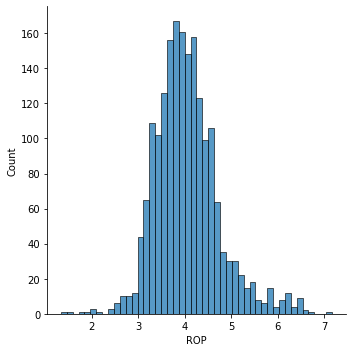

In [14]:
import seaborn as sns
import numpy as np

sns.displot(np.log(df.ROP))

Rather than transforming the target itself (which is fiddly), we'll transform it using `sklearn` later.

Check some feature distributions etc.

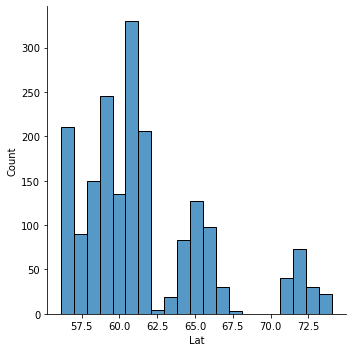

In [15]:
sns.displot(df.Lat)

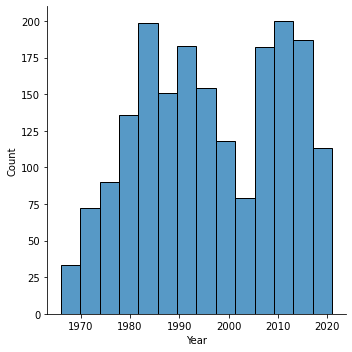

In [16]:
sns.displot(df.Year)

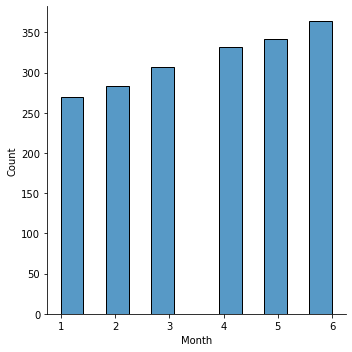

In [17]:
sns.displot(df.Month)

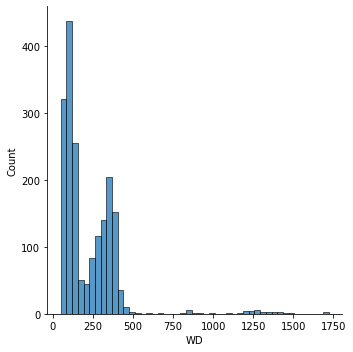

In [18]:
sns.displot(df.WD)

The model does quite a bit better on deep-water wells. Conversely, if you limit it to only shallow wells, the model is very bad!

In [19]:
# df = df.loc[df.WD > 500]

## Try a model

### EXERCISE

Make `X` and `y` from the dataframe, then split them into `train`, `val`, and `test` datasets. Use at least 80% of the data for training the model.

In [20]:
# YOUR CODE HERE



In [21]:
features = [
    'Year', 'Month',
    'Wildcat', 'Platform',
    'Lat', 'Lon',
    'WD', 'Inclination',
]
X = df[features].values
y = df['ROP'].values

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=13)

X_train.shape, X_val.shape, X_test.shape

((1517, 8), (190, 8), (190, 8))

It's probably a good idea to check some distributions against each other at this point.

### EXERCISE

Try fitting a model to the data. For example, you can try:

- `RandomForestRegressor`
- `GradientBoostingRegressor`
- `KNeighborsRegressor`
- `Ridge`
- `MLPRegressor`

In [23]:
# YOUR CODE HERE



In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor

# We can choose a regressor.
reg = RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)
# reg = GradientBoostingRegressor(max_depth=8, n_estimators=200, random_state=42)
# reg = MLPRegressor(hidden_layer_sizes=[16, 16])
# reg = Ridge()
# reg = DummyRegressor()

# Or we can pour several estimators into a voting regressor.
reg1 = GradientBoostingRegressor(max_depth=7, random_state=1)
reg2 = RandomForestRegressor(max_depth=7, random_state=1)
reg3 = Ridge()
reg4 = MLPRegressor(hidden_layer_sizes=[16, 16], max_iter=500)
reg5 = KNeighborsRegressor()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('mlp', reg4), ('knr', reg5)])

# We can use this with any transformer, or a function+inverse.
clf = TransformedTargetRegressor(regressor=ereg,
                                 func=np.log,
                                 inverse_func=np.exp
                                 )

model = make_pipeline(StandardScaler(), clf)

model.fit(X_train, y_train)

/home/matt/miniconda3/envs/geoml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=VotingRegressor(estimators=[('gb',
                                                                                   GradientBoostingRegressor(max_depth=7,
                                                                                                             random_state=1)),
                                                                                  ('rf',
                                                                                   RandomForestRegressor(max_depth=7,
                                                                                                         random_state=1)),
                                                                                  ('lr',
      

In [25]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_val)

print(r2_score(y_val, y_pred))
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.3135955318725827
50.40157287719724


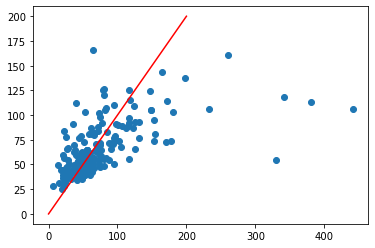

In [26]:
plt.scatter(y_val, y_pred)
plt.plot((0, 200), (0, 200), 'r')

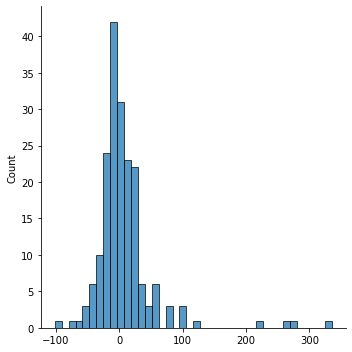

In [27]:
sns.displot(y_val - y_pred)

In [28]:
# Because the regressor is inside the voting regressor,
# which is inside the transformed-target-regressor...
rf_ = model.named_steps['transformedtargetregressor'].regressor_.named_estimators_['rf']
rf_.feature_importances_

array([0.31358784, 0.04131783, 0.02125055, 0.01158996, 0.16389177,
       0.15811714, 0.12718927, 0.16305564])

In [29]:
features

['Year', 'Month', 'Wildcat', 'Platform', 'Lat', 'Lon', 'WD', 'Inclination']

The feature importances seem reasonable, but this model performs rather poorly.

It also seems quite sensitive; small changes in conditions give very different answers. This is not a good feature of a predictive model.

It's debatable whether we can expand the dataset; possibly data from the UKCS would help, but data from GOM won't.

The best idea is probably to try to extract some more useful features. Ideas:

- Operator
- Drilling contractor
- Primary target
- Prognosed thicknesses of various formations
